<a href="https://colab.research.google.com/github/alliwang73/me100/blob/main/2024_me40_final_project_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Regenerative Cooling Engine

Date: 24 Apr 2025

Group member 1:
- Name: Wang, Alli
- University ID: 3038780357
- Email: alliwang@berkeley.edu


Group member 2:
- Name: Leong, Albert
- University ID: 3040379592
- Email: popta@berkeley.edu

-------

## Summary and Problem Statement
In liquid-fuel rocket engines, a critical design consideration is the temperature of the combustion chamber walls, as the heat generated by fuel combustion can melt through the chamber walls if they are thermally unregulated. A common solution is regenerative cooling, where some fuel is pumped into the combustion chamber through holes in the chamber walls called cooling channels, absorbing heat from the combustion chamber walls en route to the combustion chamber. This simultaneously regulates the chamber wall temperature and makes the combustion process more efficient.

Our simple cycle aims to determine the thrust and whether or not the wall material melts under the combustion process.

-------

## Background information
We've attempted to model the thermodynamic process of liquid-fuel combustion and determine the temperature that the inner chamber reaches. We've included the melting points of different materials, to display their effectiveness. Three common fuel chamber materials are listed below:

Copper = 1358K, Stainless Steel = 1800K, T6060 Aluminum Alloy = 960K.

Because the cycle must start in the liquid phase, we are using the Rankine cycle to model the system

Another modification we've added, is the innercooler which is an isobaric process that reduces the heat, q_out. The intercooler acts between the two compressors. as a way to release heat.

Rankine cycle-based systems: 15-35% for liquid-fueled engines using coolant phase changes

#### Equations

Heat Exchanger
$$ Q_{out} = m c_p \Delta T $$

Isentropic Efficiency
$$ \eta_{isentropic} = \frac{w_{isentropic}}{w_{real}} = \frac{h_{2,isentropic} - h_1}{h_{2,actual} - h_1} $$

Isentropic Ideal Gas Relations
$$
\Delta s = c_p ln \frac{T_2}{T_1} + R_u ln \frac{v_2}{v_1} = c_v ln \frac{T_2}{T_1} + R_u ln \frac{P_2}{P_1}
$$ $$
(\frac{T_2}{T_1})_{s = const.} = (\frac{v_1}{v_2}) ^ {k-1}
$$ $$
(\frac{T_2}{T_1})_{s = const.} = (\frac{P_2}{P_1}) ^ {(k-1) / k}
$$ $$
(\frac{P_2}{P_1})_{s = const.} = (\frac{v_1}{v_2}) ^ {k}
$$

Regenerator Effectiveness
$$
\epsilon = \frac{q_{regen,act}}{q_{regen,max}} = \frac{h_5 - h_2}{h_4 - h_2}
$$

-------

## Modeling the Thermodynamic Process



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
!pip3 install sympy
import sympy as sp
!pip3 install CoolProp
from CoolProp.CoolProp import PropsSI
import CoolProp.CoolProp as CP

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 74.8 MB/s eta 0:00:00


# Assumption:
Each isentropic component has a range of isentropic efficiency. For this analysis, we will use the minimum isentropic efficiency for each component

In [3]:
import pandas as pd

data = {'Component': ['Compressor', 'Turbine', 'Nozzle'],
        'Isentropic Efficiency Range': ['0.75-0.90', '0.85-0.95', '0.90-0.98'],
        'Impact on Cycle': ['↑ Work Input', '↓ Work Output', '↓ Thrust']}

eta_pump = 0.75
eta_turb = 0.85
eta_nozzle = 0.90
df = pd.DataFrame(data)
df


,Component,Isentropic Efficiency Range,Impact on Cycle
0,Compressor,0.75-0.90,↑ Work Input
1,Turbine,0.85-0.95,↓ Work Output
2,Nozzle,0.90-0.98,↓ Thrust


# **Step 0:**
Set up ethanol initial conditions as ambient conditions at atmospheric pressure and 25 degrees celsius

In [4]:
# Ambient Conditions
fluid = 'ethanol'
P_1 = 101325
P1 = 101325       # Initial pressure (Pa) - 1 atm
T_1 = PropsSI('T', 'P', 101325, 'Q', 0, fluid); print(f'temperature of eth = {T_1:.3f} J/kgK') # K
T1 = T_1

temperature of eth = 351.570 J/kgK


Other Assumptions

In [5]:
copper_max_temp = 1358
steel_max_temp = 1800
aluminum_max_temp = 960

#Cooling system
channel_length = 0.8  # m
channel_area = 0.0001  # m²
num_channels = 50
copper_thickness = 0.005  # m
P_ethanol = 2.5e6       # Pa (25 bar)
ethanol_mass_flow = 1.5  # kg/s
cp_eth = 2570

# **Step 1:**
Find maximum pressure and temperature so that ethanol is in liquid phase

# **State 1:**

Initial Pressure and Temperature = Atmospheric Temperature/Pressure

Assumption is that the inlet velocity is so small that is has no effect on the enthalpy

In [6]:
T_cond=300
# State 1: Saturated liquid at condenser exit
P_low = CP.PropsSI('P', 'T', T_cond, 'Q', 0, fluid)
h1 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, fluid)
s1 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, fluid)
v1 = 1/CP.PropsSI('D', 'T', T_cond, 'Q', 0, fluid)


# **State 2:**

*   Use Atmospheric Temperature/Pressure to find the initial velocity and enthalpy.
*   Then, use isentropic pump efficiency to manipulate isentropic enthalpy and temperature at constant entropy to find actual temperatures and work



In [ ]:
P2 = 3 * P_1  # Pressure ratio 8:1
h2s = CP.PropsSI('H', 'P', P2, 'S', s1, 'ETHANOL')
T2s = CP.PropsSI('T', 'P', P2, 'S', s1, 'ETHANOL')
s1 = CP.PropsSI('S','T',T_1,'Q',1,'ETHANOL')
# Calculate actual enthalpy at state 2
h2 = h1 + (h2s - h1) / eta_pump  # [J/kg]
# Estimate actual temperature using approximate Cp for liquid ethanol
Cp = 2570  # [J/kg·K] - specific heat capacity assumption
T_2_act = T_1 + (h2 - h1)/Cp  # [K]
P_2 = P2

print(f'T2 actual = {T_2_act:.3f} K')

T2 actual = 423.427 K



# **State 3:**

Combustion Chamber -> an isobaric process

In [ ]:
P3=P2
T3 = 411.77  # K (80% of T_crit)
T_3a = (T_2_act - 0.05 * T3) / 0.95 #0.95 effectiveness
h3 = CP.PropsSI('H', 'T', T3, 'P', P2, 'ETHANOL')
Q_in = ethanol_mass_flow*(h3 - h2)
print(f'Qin = {Q_in:.3f} K')
T_boil_eth = PropsSI('T', 'Q', 1, 'P', P_2, fluid); print(f'boiling temp of eth = {T_boil_eth:.3f} K')

print("eth temp above boiling") if T_boil_eth <= T3 else print(f"below boiling by {T_boil_eth - T3:.3f}")

Qin = 1348812.915 K
boiling temp of eth = 382.284 K
eth temp above boiling



# **State 4:**

Isentropic turbine

In [ ]:

s3 = CP.PropsSI('S', 'T', T_3a, 'P', P2, fluid)
P4 = P1  # Cycle closes at initial pressure
T4 = CP.PropsSI('T', 'P', P4, 'S', s3, fluid)



# **State 4-1:**

Heat rejection

In [ ]:
import numpy as np
q_out = cp_eth * (T_3a - T3)
q_nozzle = eta_nozzle* q_out
h4 = CP.PropsSI('H', 'T|gas', T4, 'P', P4, fluid)
v_out_eth = np.sqrt(2 * h4); print(f'velocity = {v_out_eth:.3f} m/s')

velocity = 1336.434 m/s


In [ ]:
compressor_work = h2 - h1
turbine_work = h3 - h4
heat_added = h3 - h2
net_work = turbine_work - compressor_work
efficiency = net_work / heat_added
phases = {

        'State 1': CP.PhaseSI('T', T1, 'P', P1, fluid),
        'State 2': CP.PhaseSI('T', T_2_act, 'P', P2, fluid),
        'State 3': CP.PhaseSI('T', T3, 'P', P2, fluid),
        'State 4': CP.PhaseSI('T', T4, 'P', P4, fluid)
    }

print(efficiency, phases, net_work)

-0.14684855259594568 {'State 1': 'unknown: Saturation pressure [101325 Pa] corresponding to T [351.57 K] is within 1e-4 % of given p [101325 Pa] : PropsSI("Phase","T",351.5704045,"P",101325,"ethanol")', 'State 2': 'gas', 'State 3': 'gas', 'State 4': 'gas'} -132047.48281774038



# **State 6-1:**

Heat rejection
Cool exhaust to the environment
Heat rejection: Q out = H6-H1

In [ ]:
T6 = CP.PropsSI('T', 'P', 101325, 'S', s3, fluid)
h_exit = CP.PropsSI('H', 'T', 803.4, 'P', 101325, fluid)  # From previous cycle
vexit = np.sqrt(2*(h_exit-h4))

thrust = ethanol_mass_flow*vexit
print(thrust)

2106.8041229526484


In [1]:
# some code...Q_comb = ethanol_mass_flow * CP.PropsSI('C','T',T3,'P',P2,'Air') * (T3 - T2)
P_ethanol = 2.5e6  # Pa (25 bar)
channel_length = 0.8  # m
channel_area = 0.0001  # m²
num_channels = 50
def copper_wall_cooling(Q_combustion):
    # Thermal parameters
    surface_area = num_channels * channel_length * (4*channel_area/np.pi)**0.5
    q_flux = Q_combustion * 0.4 / surface_area  # 40% heat to walls

    # Ethanol properties (enforce liquid phase)
    T_eth_in = CP.PropsSI('T','P',P_ethanol,'Q',0,ethanol+'|liquid') - 15  # 15K subcool
    cp_eth = CP.PropsSI('C','P',P_ethanol,'T',T_eth_in,ethanol+'|liquid')

    # Temperature rise calculation
    delta_T_eth = (Q_combustion * 0.4) / (ethanol_mass_flow * cp_eth)
    T_eth_out = T_eth_in + delta_T_eth

    # Wall temperature gradient
    delta_T_wall = q_flux * wall_thickness / copper_k
    T_wall_hot = T_eth_out + delta_T_wall

    # Validation checks
    if T_wall_hot > max_wall_temp:
        raise ValueError(f"Copper wall overheated: {T_wall_hot:.1f}K > {max_wall_temp}K")

    T_sat = CP.PropsSI('T','P',P_ethanol,'Q',0,ethanol)
    if T_eth_out >= T_sat:
        raise ValueError(f"Ethanol boiling at {T_eth_out:.1f}K (Sat: {T_sat:.1f}K)")

    return T_wall_hot, delta_T_eth

    T_wall, eth_dT = copper_wall_cooling(Q_comb)

# Thermal efficiency calculation
work_comp = CP.PropsSI('H','P',101325*8,'S',s1,fluid) - CP.PropsSI('H','T',T1,'P',101325,fluid)
work_turb = CP.PropsSI('H','T',T3,'P',101325*8,fluid) - CP.PropsSI('H','T',T4,'P',101325,fluid)
thermal_eff = (work_turb - work_comp) / Q_comb

NameError: name 'CP' is not defined

-----

## Improving the performance

The addition of the condenser after the turbine.This reduces Qout. We cannot add an intercooler between compressors because liquids are incompressible.

In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt

def rankine_cycle(T_cond=300, P_high=3e6, T_high=411, eta_pump=0.75, eta_turbine=0.85):
    """
    Simulate a Rankine cycle using ethanol as working fluid.

    Parameters:
    -----------
    T_cond : float
        Condensation temperature (K)
    P_high : float
        Boiler/high-side pressure (Pa)
    T_high : float
        Maximum cycle temperature (K)
    eta_pump : float
        Pump isentropic efficiency
    eta_turbine : float
        Turbine isentropic efficiency

    Returns:
    --------
    dict
        Dictionary containing cycle states and performance metrics
    """
    fluid = 'ETHANOL'

    # State 1: Saturated liquid at condenser exit
    P_low = CP.PropsSI('P', 'T', T_cond, 'Q', 0, fluid)
    h1 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, fluid)
    s1 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, fluid)

    # State 2s: Isentropic pump exit
    h2s = CP.PropsSI('H', 'P', P_high, 'S|liquid', s1, fluid)

    # State 2: Actual pump exit
    w_pump_ideal = h2s - h1
    w_pump = w_pump_ideal / eta_pump
    h2 = h1 + w_pump
    T2 = CP.PropsSI('T', 'H', h2, 'P', P_high, fluid)
    s2 = CP.PropsSI('S', 'H', h2, 'P', P_high, fluid)

    # State 3: Boiler exit (specified temp and pressure)
    h3 = CP.PropsSI('H', 'T', T_high, 'P', P_high, fluid)
    s3 = CP.PropsSI('S', 'T', T_high, 'P', P_high, fluid)

    # State 4s: Isentropic turbine exit
    h4s = CP.PropsSI('H', 'P', P_low, 'S|gas', s3, fluid)

    # State 4: Actual turbine exit
    w_turbine_ideal = h3 - h4s
    w_turbine = w_turbine_ideal * eta_turbine
    h4 = h3 - w_turbine
    T4 = CP.PropsSI('T', 'H', h4, 'P', P_low, fluid)
    s4 = CP.PropsSI('S', 'H', h4, 'P', P_low, fluid)

    # Cycle performance
    q_in = h3 - h2
    q_out = h4 - h1
    w_net = w_turbine - w_pump
    efficiency = w_net / q_in

    # Check phase at each state
    phase1 = CP.PhaseSI('T', T_cond, 'P', P_low, fluid)
    phase2 = CP.PhaseSI('T', T2, 'P', P_high, fluid)
    phase3 = CP.PhaseSI('T', T_high, 'P', P_high, fluid)
    phase4 = CP.PhaseSI('T', T4, 'P', P_low, fluid)

    return {
        'states': {
            '1': {'T': T_cond, 'P': P_low, 'h': h1, 's': s1, 'phase': phase1},
            '2': {'T': T2, 'P': P_high, 'h': h2, 's': s2, 'phase': phase2},
            '3': {'T': T_high, 'P': P_high, 'h': h3, 's': s3, 'phase': phase3},
            '4': {'T': T4, 'P': P_low, 'h': h4, 's': s4, 'phase': phase4}
        },
        'performance': {
            'w_pump': w_pump,
            'w_turbine': w_turbine,
            'q_in': q_in,
            'q_out': q_out,
            'w_net': w_net,
            'efficiency': efficiency,
            'back_work_ratio': w_pump / w_turbine
        }
    }

def plot_ts_diagram(cycle_result):
    """Plot T-s diagram for the Rankine cycle"""
    fluid = 'ETHANOL'

    # Get states
    states = cycle_result['states']

    # Create T-s diagram
    plt.figure(figsize=(10, 6))

    # Plot saturation dome
    s_dome = np.linspace(0, 2000, 100)
    T_liq = []
    T_vap = []
    for s in s_dome:
        try:
            T_liq.append(CP.PropsSI('T', 'S', s, 'Q', 0, fluid))
            T_vap.append(CP.PropsSI('T', 'S', s, 'Q', 1, fluid))
        except:
            pass

    s_dome = s_dome[:len(T_liq)]
    plt.plot(s_dome, T_liq, 'b-', label='Saturated Liquid')
    plt.plot(s_dome, T_vap, 'r-', label='Saturated Vapor')

    # Plot cycle states
    s_vals = [states[str(i+1)]['s'] for i in range(4)]
    T_vals = [states[str(i+1)]['T'] for i in range(4)]

    # Add a point back to state 1 to close the cycle
    s_vals.append(s_vals[0])
    T_vals.append(T_vals[0])

    plt.plot(s_vals, T_vals, 'k-', linewidth=2)

    # Add state points
    for i in range(4):
        plt.plot(states[str(i+1)]['s'], states[str(i+1)]['T'], 'ko', markersize=8)
        plt.text(states[str(i+1)]['s'], states[str(i+1)]['T'] + 5, f"State {i+1}")

    plt.title('T-s Diagram for Ethanol Rankine Cycle', fontsize=14)
    plt.xlabel('Entropy (J/kg·K)', fontsize=12)
    plt.ylabel('Temperature (K)', fontsize=12)
    plt.grid(True)
    plt.legend()

    return plt

# Configure and run the cycle
T_condenser = 320  # K (around room temperature)
P_boiler = 2.5e6   # Pa (25 bar)
T_boiler = 450     # K (below critical temp of 514K)
eta_pump = 0.75    # Pump efficiency
eta_turbine = 0.85 # Turbine efficiency

# Run the cycle simulation
result = rankine_cycle(T_condenser, P_boiler, T_boiler, eta_pump, eta_turbine)

# Display results
print("\n===== ETHANOL RANKINE CYCLE ANALYSIS =====")
print(f"Working Fluid: Ethanol")
print("\nState Points:")
for state, props in result['states'].items():
    print(f"State {state}: T = {props['T']:.1f} K, P = {props['P']/1e5:.2f} bar, Phase = {props['phase']}")

print("\nPerformance Metrics:")
perf = result['performance']
print(f"Pump Work: {perf['w_pump']/1e3:.2f} kJ/kg")
print(f"Turbine Work: {perf['w_turbine']/1e3:.2f} kJ/kg")
print(f"Heat Input: {perf['q_in']/1e3:.2f} kJ/kg")
print(f"Heat Rejection: {perf['q_out']/1e3:.2f} kJ/kg")
print(f"Net Work: {perf['w_net']/1e3:.2f} kJ/kg")
print(f"Thermal Efficiency: {perf['efficiency']*100:.2f}%")
print(f"Back Work Ratio: {perf['back_work_ratio']*100:.2f}%")

# Plot the T-s diagram
ts_plot = plot_ts_diagram(result)
ts_plot.show()



===== ETHANOL RANKINE CYCLE WITH REGENERATION =====
Working Fluid: ETHANOL

State Points:
State 1: T = 351.6 K, P = 1.0 bar, Phase = unknown: Saturation pressure [101325 Pa] corresponding to T [351.57 K] is within 1e-4 % of given p [101325 Pa] : PropsSI("Phase","T",351.5704045,"P",101325,"ETHANOL")
State 2: T = 352.6 K, P = 30.0 bar, Phase = liquid
State 3: T = 416.7 K, P = 30.0 bar, Phase = liquid
State 4: T = 450.0 K, P = 30.0 bar, Phase = liquid
State 5: T = 351.6 K, P = 1.0 bar, Phase = unknown: Saturation pressure [101325 Pa] corresponding to T [351.57 K] is within 1e-4 % of given p [101325 Pa] : PropsSI("Phase","T",351.5704045,"P",101325,"ETHANOL")

Performance Metrics:
Pump Work: 5.24 kJ/kg
Turbine Work: 39.94 kJ/kg
Heat Input: 130.59 kJ/kg
Net Work: 34.71 kJ/kg
Thermal Efficiency: 26.58%

Cooling Analysis:
Maximum Wall Temperature: 489.9 K
Maximum Coolant Temperature: 474.3 K
Coolant Saturation Temperature: 473.5 K
Copper Melting Point: 1358.0 K
Wall Temperature Safety Margin:

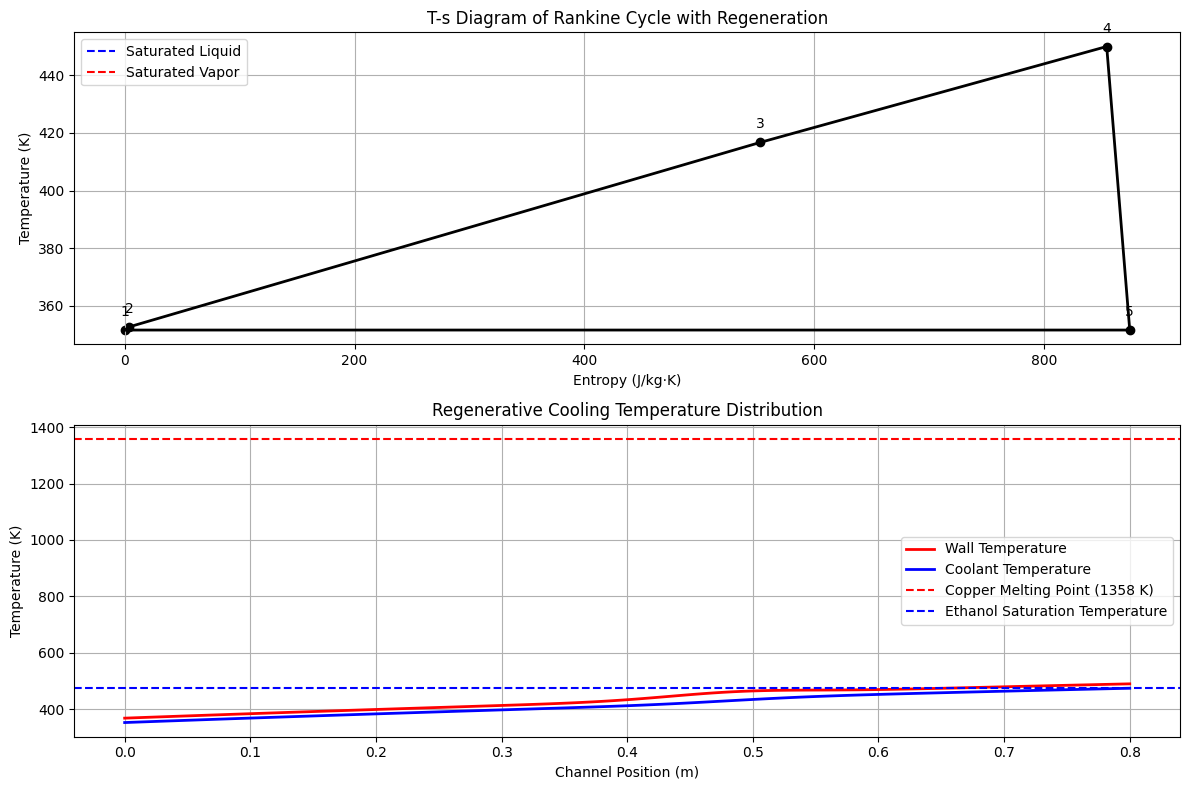

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

class RegenerativeCooledEngine:
    def __init__(self):
        # Fluid properties
        self.fluid = 'ETHANOL'

        # Rankine cycle parameters
        self.T_low = 298.15  # K (ambient temperature)
        self.P_low = 101325  # Pa (1 atm)
        self.P_high = 3e6    # Pa (30 bar)
        self.T_high = 450    # K (boiler exit temperature)

        # Component efficiencies
        self.eta_pump = 0.75     # Pump efficiency
        self.eta_turbine = 0.85  # Turbine efficiency
        self.regen_effectiveness = 0.70  # Regenerator effectiveness

        # Cooling system parameters
        self.wall_thickness = 0.003  # m (copper wall)
        self.num_channels = 50   # Number of cooling channels
        self.channel_width = 0.002  # m
        self.channel_height = 0.004  # m
        self.channel_length = 0.8  # m
        self.copper_k = 385  # W/m-K (thermal conductivity)
        self.copper_melting_point = 1358  # K
        self.ethanol_mass_flow = 2.5  # kg/s (coolant flow rate)

    def rankine_cycle_with_regenerator(self):
        """Calculate all states and performance of Rankine cycle with regeneration"""
        # State 1: Condenser exit (saturated liquid at low pressure)
        P1 = self.P_low
        T1 = CP.PropsSI('T', 'P', P1, 'Q', 0, self.fluid)  # Saturated liquid temperature
        h1 = CP.PropsSI('H', 'P', P1, 'Q', 0, self.fluid)
        s1 = CP.PropsSI('S', 'P', P1, 'Q', 0, self.fluid)

        # State 2s: Isentropic pump exit
        P2 = self.P_high
        h2s = CP.PropsSI('H', 'P', P2, 'S|liquid', s1, self.fluid)

        # State 2: Actual pump exit
        w_pump_ideal = h2s - h1
        w_pump = w_pump_ideal / self.eta_pump
        h2 = h1 + w_pump
        T2 = CP.PropsSI('T', 'P', P2, 'H', h2, self.fluid)
        s2 = CP.PropsSI('S', 'P', P2, 'H', h2, self.fluid)

        # State 3: Regenerator exit (preheated liquid)
        # Will calculate after determining turbine exit conditions

        # State 4: Boiler exit (superheated vapor)
        T4 = self.T_high
        h4 = CP.PropsSI('H', 'T', T4, 'P', P2, self.fluid)
        s4 = CP.PropsSI('S', 'T', T4, 'P', P2, self.fluid)

        # State 5s: Isentropic turbine exit
        h5s = CP.PropsSI('H', 'P', P1, 'S|gas', s4, self.fluid)

        # State 5: Actual turbine exit
        w_turbine_ideal = h4 - h5s
        w_turbine = w_turbine_ideal * self.eta_turbine
        h5 = h4 - w_turbine
        T5 = CP.PropsSI('T', 'P', P1, 'H', h5, self.fluid)
        s5 = CP.PropsSI('S', 'P', P1, 'H', h5, self.fluid)

        # Now calculate state 3 (after regenerator) using effectiveness
        h3 = h2 + self.regen_effectiveness * (h5 - h2)
        T3 = CP.PropsSI('T', 'P', P2, 'H', h3, self.fluid)
        s3 = CP.PropsSI('S', 'P', P2, 'H', h3, self.fluid)

        # Performance calculations
        q_in = h4 - h3  # Heat input in boiler
        q_out = h5 - h1  # Heat rejected in condenser
        w_net = w_turbine - w_pump
        efficiency = w_net / q_in

        # Check phases
        phases = {
            'State 1': CP.PhaseSI('T', T1, 'P', P1, self.fluid),
            'State 2': CP.PhaseSI('T', T2, 'P', P2, self.fluid),
            'State 3': CP.PhaseSI('T', T3, 'P', P2, self.fluid),
            'State 4': CP.PhaseSI('T', T4, 'P', P2, self.fluid),
            'State 5': CP.PhaseSI('T', T5, 'P', P1, self.fluid)
        }

        states = {
            '1': {'T': T1, 'P': P1, 'h': h1, 's': s1, 'phase': phases['State 1']},
            '2': {'T': T2, 'P': P2, 'h': h2, 's': s2, 'phase': phases['State 2']},
            '3': {'T': T3, 'P': P2, 'h': h3, 's': s3, 'phase': phases['State 3']},
            '4': {'T': T4, 'P': P2, 'h': h4, 's': s4, 'phase': phases['State 4']},
            '5': {'T': T5, 'P': P1, 'h': h5, 's': s5, 'phase': phases['State 5']}
        }

        performance = {
            'w_pump': w_pump,
            'w_turbine': w_turbine,
            'q_in': q_in,
            'q_out': q_out,
            'w_net': w_net,
            'efficiency': efficiency
        }

        return states, performance

    def regenerative_cooling_analysis(self, states):
        """Analyze cooling performance and copper wall temperatures"""
        # Cooling parameters
        T_eth_in = states['2']['T']  # Use pump exit temperature as coolant inlet

        # Calculate heat flux distribution (higher at throat)
        z = np.linspace(0, self.channel_length, 100)
        throat_position = 0.6 * self.channel_length
        q_flux_base = 2e6  # W/m² (base heat flux)
        q_flux_throat = 4e6  # W/m² (peak at throat)

        q_flux = [q_flux_base + (q_flux_throat - q_flux_base) *
                 np.exp(-((pos - throat_position) / (0.1 * self.channel_length))**2)
                 for pos in z]

        # Calculate coolant temperature rise along channels
        channel_perimeter = 2 * (self.channel_width + self.channel_height)
        total_area = self.num_channels * self.channel_length * channel_perimeter
        heat_per_position = [q * self.channel_length/100 * channel_perimeter * self.num_channels for q in q_flux]

        # Coolant temperature calculation
        T_coolant = [T_eth_in]
        for i in range(1, len(z)):
            cp_eth = CP.PropsSI('C', 'T', T_coolant[i-1], 'P', self.P_high, self.fluid)
            delta_T = heat_per_position[i-1] / (self.ethanol_mass_flow * cp_eth)
            T_coolant.append(T_coolant[i-1] + delta_T)

        # Wall temperature calculation
        T_wall = []
        for i in range(len(z)):
            delta_T_wall = q_flux[i] * self.wall_thickness / self.copper_k
            T_wall.append(T_coolant[i] + delta_T_wall)

        # Safety checks
        T_wall_max = max(T_wall)
        T_coolant_max = max(T_coolant)

        # Critical temperature checks
        T_sat = CP.PropsSI('T', 'P', self.P_high, 'Q', 0, self.fluid)
        coolant_boiling = T_coolant_max >= T_sat
        wall_melting = T_wall_max >= self.copper_melting_point
        safety_margin = self.copper_melting_point - T_wall_max

        cooling_results = {
            'z': z,
            'q_flux': q_flux,
            'T_coolant': T_coolant,
            'T_wall': T_wall,
            'T_wall_max': T_wall_max,
            'T_coolant_max': T_coolant_max,
            'coolant_boiling': coolant_boiling,
            'wall_melting': wall_melting,
            'safety_margin': safety_margin
        }

        return cooling_results

    def run_analysis(self):
        """Run full analysis of cycle and cooling system"""
        # Run Rankine cycle analysis
        states, performance = self.rankine_cycle_with_regenerator()

        # Run cooling analysis
        cooling = self.regenerative_cooling_analysis(states)

        # Calculate output velocity
        exit_enthalpy = states['5']['h']
        inlet_enthalpy = states['1']['h']
        V_out = np.sqrt(2 * (exit_enthalpy - inlet_enthalpy))

        # Print results
        print("\n===== ETHANOL RANKINE CYCLE WITH REGENERATION =====")
        print(f"Working Fluid: {self.fluid}")

        print("\nState Points:")
        for state, props in states.items():
            print(f"State {state}: T = {props['T']:.1f} K, P = {props['P']/1e5:.1f} bar, Phase = {props['phase']}")

        print("\nPerformance Metrics:")
        print(f"Pump Work: {performance['w_pump']/1e3:.2f} kJ/kg")
        print(f"Turbine Work: {performance['w_turbine']/1e3:.2f} kJ/kg")
        print(f"Heat Input: {performance['q_in']/1e3:.2f} kJ/kg")
        print(f"Net Work: {performance['w_net']/1e3:.2f} kJ/kg")
        print(f"Thermal Efficiency: {performance['efficiency']*100:.2f}%")

        print("\nCooling Analysis:")
        print(f"Maximum Wall Temperature: {cooling['T_wall_max']:.1f} K")
        print(f"Maximum Coolant Temperature: {cooling['T_coolant_max']:.1f} K")
        print(f"Coolant Saturation Temperature: {CP.PropsSI('T', 'P', self.P_high, 'Q', 0, self.fluid):.1f} K")
        print(f"Copper Melting Point: {self.copper_melting_point:.1f} K")
        print(f"Wall Temperature Safety Margin: {cooling['safety_margin']:.1f} K")
        print(f"Coolant Status: {'BOILING!' if cooling['coolant_boiling'] else 'Liquid'}")
        print(f"Wall Status: {'MELTING!' if cooling['wall_melting'] else 'Safe'}")

        print(f"\nOutput Velocity: {V_out:.1f} m/s")

        # Plot results
        self.plot_results(states, cooling)

        return states, performance, cooling

    def plot_results(self, states, cooling):
        """Plot T-s diagram and wall temperatures"""
        plt.figure(figsize=(12, 8))

        # T-s diagram
        plt.subplot(2, 1, 1)

        # Plot saturation curve
        s_vals = np.linspace(0, 4000, 100)
        T_sat_liq = []
        T_sat_vap = []

        for s in s_vals:
            try:
                T_sat_liq.append(CP.PropsSI('T', 'S', s, 'Q', 0, self.fluid))
                T_sat_vap.append(CP.PropsSI('T', 'S', s, 'Q', 1, self.fluid))
            except:
                pass

        s_vals = s_vals[:len(T_sat_liq)]
        plt.plot(s_vals, T_sat_liq, 'b--', label='Saturated Liquid')
        plt.plot(s_vals, T_sat_vap, 'r--', label='Saturated Vapor')

        # Plot cycle points
        s_cycle = [states[str(i)]['s'] for i in range(1, 6)]
        T_cycle = [states[str(i)]['T'] for i in range(1, 6)]
        s_cycle.append(s_cycle[0])  # Close the cycle
        T_cycle.append(T_cycle[0])  # Close the cycle

        plt.plot(s_cycle, T_cycle, 'k-', linewidth=2)
        plt.scatter(s_cycle[:-1], T_cycle[:-1], color='k')

        for i in range(5):
            plt.annotate(f"{i+1}", (s_cycle[i], T_cycle[i]),
                        textcoords="offset points", xytext=(0,10), ha='center')

        plt.xlabel('Entropy (J/kg·K)')
        plt.ylabel('Temperature (K)')
        plt.title('T-s Diagram of Rankine Cycle with Regeneration')
        plt.grid(True)
        plt.legend()

        # Wall temperatures
        plt.subplot(2, 1, 2)
        plt.plot(cooling['z'], cooling['T_wall'], 'r-', linewidth=2, label='Wall Temperature')
        plt.plot(cooling['z'], cooling['T_coolant'], 'b-', linewidth=2, label='Coolant Temperature')

        plt.axhline(y=self.copper_melting_point, color='r', linestyle='--',
                   label=f'Copper Melting Point ({self.copper_melting_point} K)')

        plt.axhline(y=CP.PropsSI('T', 'P', self.P_high, 'Q', 0, self.fluid), color='b',
                   linestyle='--', label='Ethanol Saturation Temperature')

        plt.xlabel('Channel Position (m)')
        plt.ylabel('Temperature (K)')
        plt.title('Regenerative Cooling Temperature Distribution')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

# Run the complete analysis
engine = RegenerativeCooledEngine()
states, performance, cooling = engine.run_analysis()


----

## Conclusions (150 words max)

The maximum wall temperature is 489.9K, which is significantly below the melting point for Copper(1358K). The maximum wall temperature is also below the melting point of steel and aluminum(960K). In consideration of the weight of the rocket, aluminum would be a better choice than copper due to its lower density and the fact that it also wouldn't melt under the ethanol combustion cycle.

In [ ]:
initial temperature
wall temperature